# Homework 04
Our goal is to predict if some given wine is either good or bad.\
In total there are 1599 different wines, each  described by 11 properties e.g. *fixed acidity, citric acid, chlorides, pH*.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

### 1. Data set
We are working with the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). We will load and split the dataset using the [pandas](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) library and convert the resulting panda dataframes to tensorflow datasets.

#### 1.1. Load Data into a Dataframe

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
dataframe = pd.read_csv(url, sep = ';')
dataframe = dataframe.sample(frac=1)#, random_state=40)
dataframe.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### 1.2. Create a Tensorflow Dataset and a Dataset Pipeline

In [3]:
def split_dataframe(dataframe, proportions={'train': 0.7,
                                            'valid': 0.15,
                                            'test': 0.15}):
    """Split the dataframe into Train, Validation and Test Tensorflow Datasets.

    :param dataframe: dataframe to be splitted
    :type dataframe: Pandas dataframe
    :param proportions: porportions by which to split the dataframe,
        defaults to {'train': 0.7,
                     'valid': 0.15,
                     'test': 0.15}
    :type proportions: dict of floats, optional
    :return: splitted datasets
    :rtype: tf.Datasets
    """
    # Split the dataset into a train, test and validation split
    assert sum(proportions.values()) <= 1,\
        "The sum of split_proportions is larger than 1!"

    #sampled_df = dataframe.sample(frac=1, random_state=sample_seed)
    split_df = np.split(dataframe,
        [int(proportions['train'] * len(dataframe)),
        int((proportions['train']+proportions['valid']) * len(dataframe))])

    tf_ds = {}
    for i in range(3):
        # seperate labels and inputs
        labels = split_df[i].pop('quality')
        key = list(proportions)[i]
        tf_ds[key] = tf.data.Dataset.from_tensor_slices((split_df[i], labels))
    return tf_ds


In [4]:
def make_binary(target, target_threshold=6):
    """Convert target in range 0..10 to binary target.

    :param target: target that should be converted
    :type target: int
    :param target_threshold: threshold from which target will be 1,
        defaults to 5
    :type target_threshold: integer, optional
    """
    return int(target >= target_threshold)

In [5]:
def preprocessing_pipeline(data):
    """Apply preproccesing pipeline to the given dataset.
    
    :param data: data to be preprocessed
    :type data: tensorflow 'Dataset'
    :return: preprocessed dataset
    :rtype: tensorflow 'Dataset'
    """
    # binarize targets
    data = data.map(lambda inputs, target: (
        inputs,
        make_binary(target)
    ))
    # cache the dataset
    data = data.cache()
    # shuffle, batch and prefetch the dataset
    data = data.shuffle(1000)
    data = data.batch(64)
    data = data.prefetch(100)
    return data

### 2. Model

In [6]:
class CustomDense(tf.keras.layers.Layer):
    """This is a custom Dense Layer class
    
    :param units: number of perceptrons in the layer
    :type units: integer
    :param activation: activation function that the perceptrons use
    :type activation: tf.nn activation function
    :param kernel_regularizer: regularizer that can be applied to the perceptron
    :type kernel_regularizer: tf.regularizer regularizer function
    """
    def __init__(self, units, activation, kernel_regularizer=None):
        """Constructor function"""
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = activation
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        """Build function runs once when first pass is executed. This way the
        input shape is dynamic.

        :param input_shape: shape of the input that feeds into the layer
        :type input_shape: tf.Tensor
        """
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 regularizer=self.kernel_regularizer)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    
    def call(self, inputs):
        """Compute forward pass through layer.

        :param inputs: Layer inputs
        :type inputs: tf.Tensor
        :return: Layer outputs
        :rtype: tf.Tensor
        """
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [7]:
class CustomModel(tf.keras.Model):
    """This is a custom model class
    
    :param loss_function: loss function used to calculate loss of the model
    :type loss_function: function from the tf.keras.losses module
    :param optimizer: optimizer used to apply gradients to the models
        trainable variables
    :type optimizer: function from the tf.keras.optimizers module
    :param layers: Contains all Layers of the model
    :type layers: list of CustomDense-Objects
    """
    def __init__(self, layer_list):
        """Constructor function"""
        super(CustomModel, self).__init__()
        self.layer_collection = layer_list
        

    def call(self, inputs):
        """Compute the feed-forward pass through all dense layers.
        
        :param inputs: network input
        :type inputs: tf.Tensor
        """
        x = inputs
        for layer in self.layer_collection:
            x = layer(x)
        return x
    
    def train_step(self, input, target, optimizer, loss_function):
        """Applys optimizer to all trainable variables of this model to
        minimize the loss (loss_function) between the target output and the
        predicted ouptut.

        :param input: input to the model
        :type input: tf.Tensor
        :param target: target output with repect to the input
        :type target: tf.Tensor
        :return: the loss and the accuracy of the models prediction
        :rtype: tuple of two floats
        """
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = loss_function(target, prediction)
            gradients = tape.gradient(loss, self.trainable_variables)
        # apply gradients to the trainable variables using a optimizer
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        accuracy = self.calc_accuracy(prediction, target)
        return loss, accuracy
    
    def test(self, test_data, loss_function):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for (input, target) in test_data:
            prediction = self(input)
            loss = loss_function(target, prediction)
            accuracy = self.calc_accuracy(prediction, target)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy
    
    def calc_accuracy(self, pred, target):
        """Calucalte accuracy between a prediction and a target.

        :param pred: a prediction that the model made
        :type pred: tf.Tensor of floats
        :param target: target that model should have predicted
        :type target: tf.Tensor of floats
        """
        same_prediction = np.round(target) == np.round(pred)
        return np.mean(same_prediction)

### 3. Training

In [8]:
def training(input_model, datasets, optimizer, loss_function, epochs=10):
    tf.keras.backend.clear_session()
    # Initialize lists for tracking loss and accuracy
    losses = {'train':[], 'valid':[], 'test':0}
    accuracies = {'train':[], 'valid':[], 'test':0}
        
    # Train-Dataset
    train_loss, train_accuracy = input_model.test(datasets['train'], loss_function)

    losses['train'].append(train_loss)
    accuracies['train'].append(train_accuracy)

    valid_loss, valid_accuracy = input_model.test(datasets['valid'], loss_function)
    #valid_losses.append(valid_loss)
    #valid_accuracies.append(valid_accuracy)
    losses['valid'].append(valid_loss)
    accuracies['valid'].append(valid_accuracy)


    # Training for EPOCHS.
    for epoch in range(1, epochs+1):
        last_valid_acc = np.round(accuracies['valid'][-1], 3)
        print(f'Epoch {str(epoch)} starting with validation accuracy of {last_valid_acc}')
        epoch_loss_agg = []
        epoch_accuracy_agg = []
        for input, target in datasets['train']:
            train_loss, train_accuracy = input_model.train_step(input, target, optimizer, loss_function)
            epoch_loss_agg.append(train_loss)
            epoch_accuracy_agg.append(train_accuracy)
        # track training loss and accuracy
        losses['train'].append(tf.reduce_mean(epoch_loss_agg))
        accuracies['train'].append(tf.reduce_mean(epoch_accuracy_agg))
        # track loss and accuracy for test-dataset
        valid_loss, valid_accuracy = input_model.test(datasets['valid'], loss_function)
        losses['valid'].append(valid_loss)
        accuracies['valid'].append(valid_accuracy)
    test_loss, test_accuracy = input_model.test(datasets['test'], loss_function)

    losses['test'] = test_loss
    accuracies['test'] = test_accuracy    

    return losses, accuracies

### 4. Fine Tuning

In [9]:
results = {}

#### 4.1 Base Model

In [10]:
# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# Initialize Model
model = CustomModel([CustomDense(32, activation=tf.nn.sigmoid),
                     CustomDense(20, activation=tf.nn.sigmoid),
                     CustomDense(1, activation=tf.nn.sigmoid)])

# Generate Datasets from Dataframe
tf_ds = split_dataframe(dataframe)
# Apply Preprocessing Pipeline to each Dataset (Train, Valid,  Test)
for key in tf_ds:
    tf_ds[key] = tf_ds[key].apply(preprocessing_pipeline)

# Train Model
losses, accuracies = training(model, tf_ds, optimizer, cross_entropy_loss, epochs=EPOCHS)
results['Base Model'] = {'losses':losses,
                         'accuracies':accuracies}
del model

Epoch 1 starting with validation accuracy of 0.5
Epoch 2 starting with validation accuracy of 0.499
Epoch 3 starting with validation accuracy of 0.503
Epoch 4 starting with validation accuracy of 0.5
Epoch 5 starting with validation accuracy of 0.505
Epoch 6 starting with validation accuracy of 0.5
Epoch 7 starting with validation accuracy of 0.5
Epoch 8 starting with validation accuracy of 0.5
Epoch 9 starting with validation accuracy of 0.504
Epoch 10 starting with validation accuracy of 0.495


#### 4.2 L2-Regularizer Model

Because of the application of L2-Regularization smaller weights tend to be preferred. As such the accuracy dosen't jump as much.

In [11]:
# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer

#def l2_regularizer(weights):
#    return tf.reduce_sum(0.02 * tf.square(weights))
l2_regularizer = lambda weights: tf.reduce_sum(0.02 * tf.square(weights))

optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# Initialize Model
model = CustomModel([CustomDense(32, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer),
                     CustomDense(20, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer),
                     CustomDense(1, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer)])

# Generate Datasets from Dataframe
tf_ds = split_dataframe(dataframe)
# Apply Preprocessing Pipeline to each Dataset (Train, Valid,  Test)
for key in tf_ds:
    tf_ds[key] = tf_ds[key].apply(preprocessing_pipeline)

# Train Model
losses, accuracies = training(model, tf_ds, optimizer, cross_entropy_loss, epochs=EPOCHS)

results['L2 Regularized Model'] = {'losses':losses, 'accuracies':accuracies}
del model

Epoch 1 starting with validation accuracy of 0.499
Epoch 2 starting with validation accuracy of 0.493
Epoch 3 starting with validation accuracy of 0.493
Epoch 4 starting with validation accuracy of 0.505
Epoch 5 starting with validation accuracy of 0.491
Epoch 6 starting with validation accuracy of 0.504
Epoch 7 starting with validation accuracy of 0.5
Epoch 8 starting with validation accuracy of 0.503
Epoch 9 starting with validation accuracy of 0.507
Epoch 10 starting with validation accuracy of 0.5


#### 4.3 Standart Scaled Model

In [12]:
# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer

optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# Initialize Model
model = CustomModel([CustomDense(32, activation=tf.nn.sigmoid),
                     CustomDense(20, activation=tf.nn.sigmoid),
                     CustomDense(1, activation=tf.nn.sigmoid)])

# Generate Datasets from Dataframe
dataframe_scaled = pd.DataFrame(StandardScaler().fit_transform(dataframe.loc[:, :'alcohol']), columns=dataframe.loc[:, :'alcohol'].columns)
dataframe_scaled['quality'] = dataframe['quality']
tf_ds = split_dataframe(dataframe_scaled)
# Apply Preprocessing Pipeline to each Dataset (Train, Valid,  Test)
for key in tf_ds:
    tf_ds[key] = tf_ds[key].apply(preprocessing_pipeline)

# Train Model
losses, accuracies = training(model, tf_ds, optimizer, cross_entropy_loss, epochs=EPOCHS)

results['Standard Scaled Model'] = {'losses':losses, 'accuracies':accuracies}
del model

Epoch 1 starting with validation accuracy of 0.4
Epoch 2 starting with validation accuracy of 0.599
Epoch 3 starting with validation accuracy of 0.455
Epoch 4 starting with validation accuracy of 0.605
Epoch 5 starting with validation accuracy of 0.6
Epoch 6 starting with validation accuracy of 0.602
Epoch 7 starting with validation accuracy of 0.607
Epoch 8 starting with validation accuracy of 0.602
Epoch 9 starting with validation accuracy of 0.6
Epoch 10 starting with validation accuracy of 0.608


#### 4.4 Adam Model

In [13]:
# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize Model
model = CustomModel([CustomDense(32, activation=tf.nn.sigmoid),
                     CustomDense(20, activation=tf.nn.sigmoid),
                     CustomDense(1, activation=tf.nn.sigmoid)])

# Generate Datasets from Dataframe
tf_ds = split_dataframe(dataframe)
# Apply Preprocessing Pipeline to each Dataset (Train, Valid,  Test)
for key in tf_ds:
    tf_ds[key] = tf_ds[key].apply(preprocessing_pipeline)

# Train Model
losses, accuracies = training(model, tf_ds, optimizer, cross_entropy_loss, epochs=EPOCHS)
results['Adam-Optimizer Model'] = {'losses':losses,
                         'accuracies':accuracies}
del model

Epoch 1 starting with validation accuracy of 0.504
Epoch 2 starting with validation accuracy of 0.5
Epoch 3 starting with validation accuracy of 0.496
Epoch 4 starting with validation accuracy of 0.495
Epoch 5 starting with validation accuracy of 0.504
Epoch 6 starting with validation accuracy of 0.5
Epoch 7 starting with validation accuracy of 0.497
Epoch 8 starting with validation accuracy of 0.51
Epoch 9 starting with validation accuracy of 0.505
Epoch 10 starting with validation accuracy of 0.493


#### 4.5. Optimized Model

In [14]:
# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.01
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer

#def l2_regularizer(weights):
#    return tf.reduce_sum(0.02 * tf.square(weights))
l2_regularizer = lambda weights: tf.reduce_sum(0.02 * tf.square(weights))

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize Model
model = CustomModel(layer_list=[CustomDense(15, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer),
                     CustomDense(30, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer),
                     tf.keras.layers.Dropout(0.5),
                     CustomDense(20, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer),
                     CustomDense(1, activation=tf.nn.sigmoid, kernel_regularizer=l2_regularizer)])

# Generate Datasets from Dataframe
dataframe_scaled = pd.DataFrame(StandardScaler().fit_transform(dataframe.loc[:, :'alcohol']), columns=dataframe.loc[:, :'alcohol'].columns)
dataframe_scaled['quality'] = dataframe['quality']
tf_ds = split_dataframe(dataframe_scaled)
# Apply Preprocessing Pipeline to each Dataset (Train, Valid,  Test)
for key in tf_ds:
    tf_ds[key] = tf_ds[key].apply(preprocessing_pipeline)

# Train Model
losses, accuracies = training(model, tf_ds, optimizer, cross_entropy_loss, epochs=EPOCHS)

results['Optimized Model'] = {'losses':losses, 'accuracies':accuracies}
del model

Epoch 1 starting with validation accuracy of 0.395
Epoch 2 starting with validation accuracy of 0.605
Epoch 3 starting with validation accuracy of 0.604
Epoch 4 starting with validation accuracy of 0.605
Epoch 5 starting with validation accuracy of 0.6
Epoch 6 starting with validation accuracy of 0.605
Epoch 7 starting with validation accuracy of 0.608
Epoch 8 starting with validation accuracy of 0.603
Epoch 9 starting with validation accuracy of 0.602
Epoch 10 starting with validation accuracy of 0.609


### 5. Visualisation

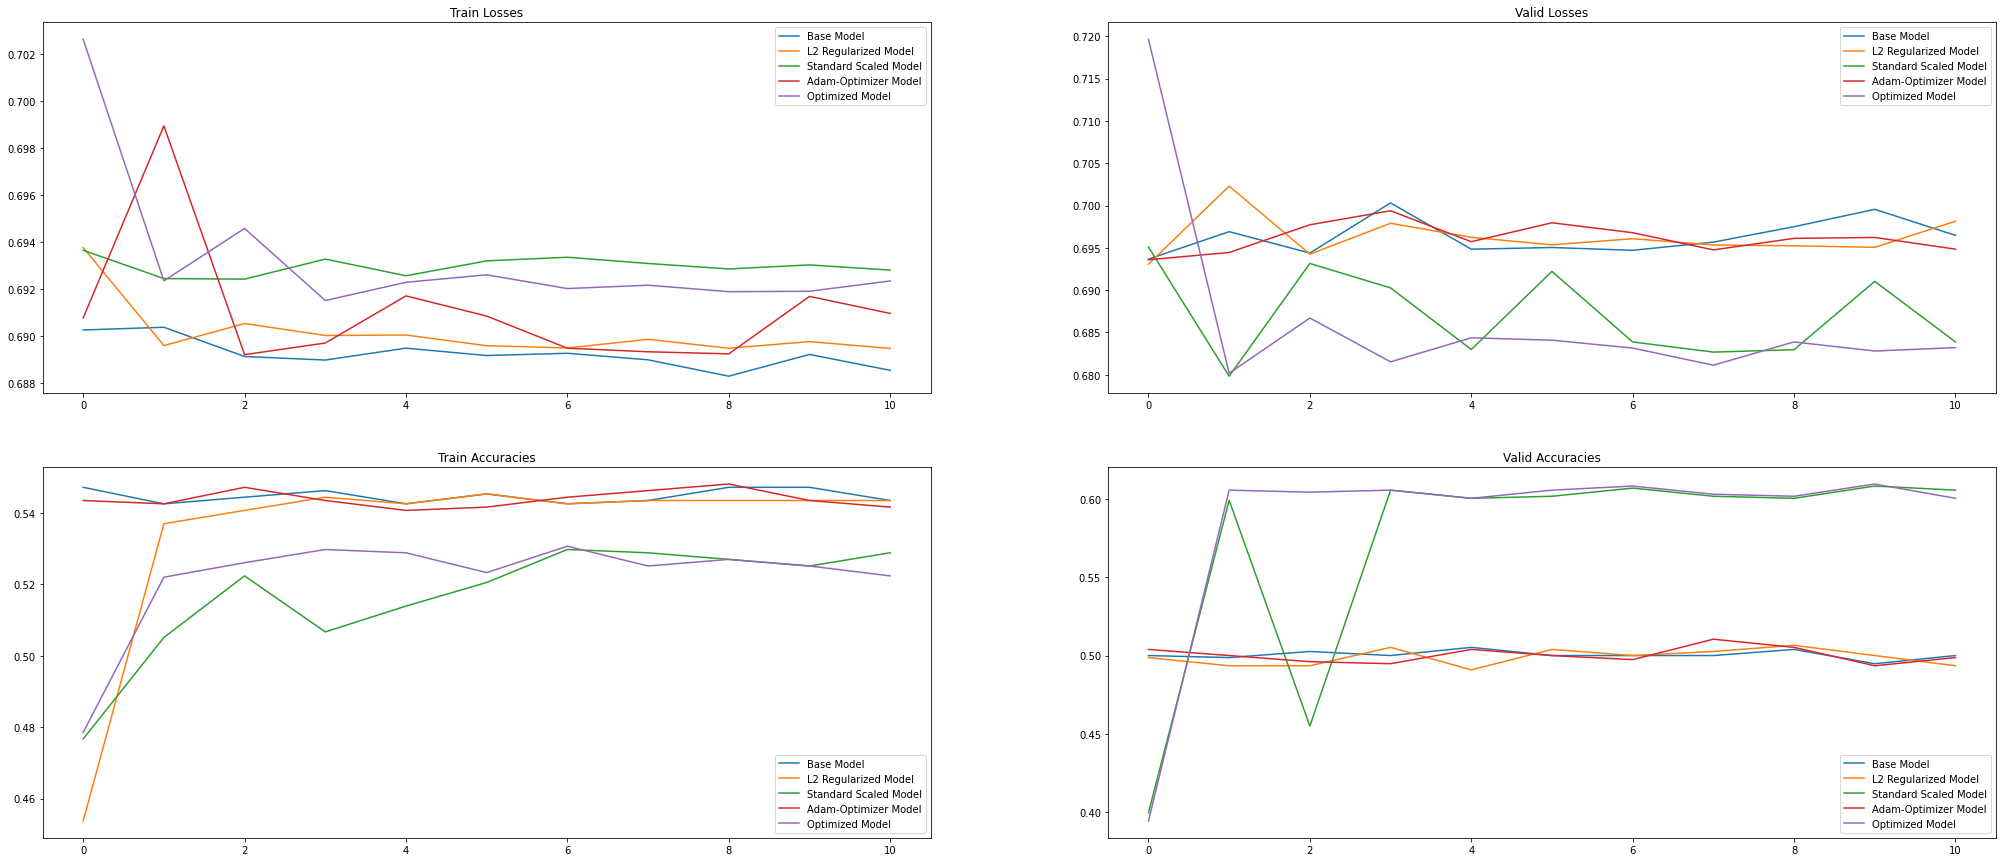

In [15]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(35,15)
for i, key in enumerate(results):
    axs[0][0].set_title('Train Losses')
    axs[0][0].plot(results[key]['losses']['train'], label=key)
    axs[0][0].legend()
    axs[1][0].set_title('Train Accuracies')
    axs[1][0].plot(results[key]['accuracies']['train'], label=key)
    axs[1][0].legend()

    axs[0][1].set_title('Valid Losses')
    axs[0][1].plot(results[key]['losses']['valid'], label=key)
    axs[0][1].legend()
    axs[1][1].set_title('Valid Accuracies')
    axs[1][1].plot(results[key]['accuracies']['valid'],  label=key)
    axs[1][1].legend()

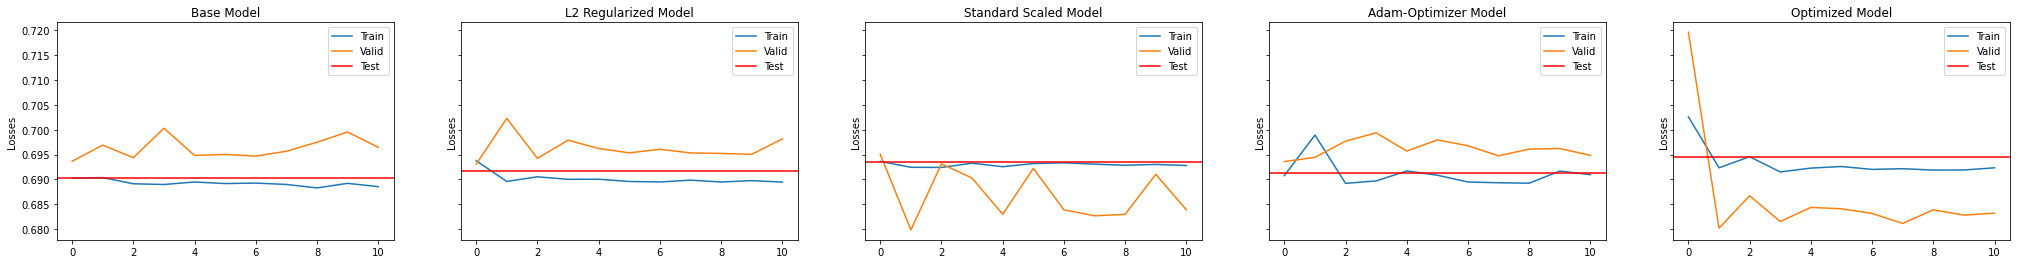

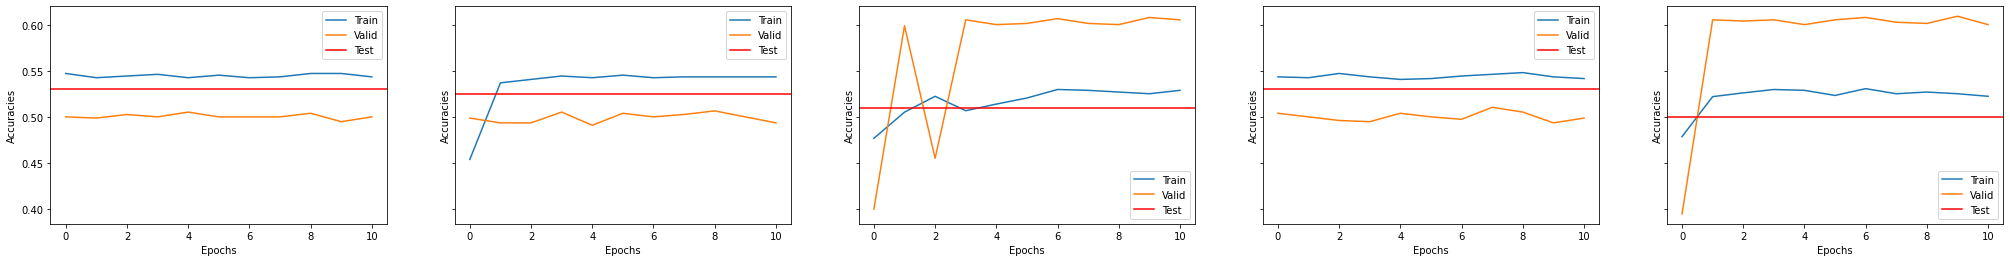

In [16]:
fig, axs = plt.subplots(1,len(results), sharey=True, sharex=False)
fig.set_size_inches(35,4)
for i, key in enumerate(results):
    axs[i].set_title(key)
    axs[i].set_ylabel('Losses')
    axs[i].plot(results[key]['losses']['train'], label='Train')
    axs[i].plot(results[key]['losses']['valid'], label='Valid')
    axs[i].axhline(y=results[key]['losses']['test'], color='r', linestyle='-', label='Test')
    axs[i].legend()

fig, axs = plt.subplots(1,len(results), sharey=True, sharex=False)
fig.set_size_inches(35,4)
for i, key in enumerate(results):
    axs[i].set_ylabel('Accuracies')
    axs[i].set_xlabel('Epochs')
    axs[i].plot(results[key]['accuracies']['train'], label='Train')
    axs[i].plot(results[key]['accuracies']['valid'], label='Valid')

    axs[i].axhline(y=results[key]['accuracies']['test'], color='r', linestyle='-', label='Test')
    axs[i].legend()
    
